# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

We {**2207ACDS_teamnd1**}, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

__The task__: _Predict an individual’s belief in climate change based on their tweets!_

__The significance__: _Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies._

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#eight>8. Conclusion</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [1]:
# Libraries for data loading, data manipulation and data visualisation

import seaborn as sns
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from sklearn.metrics import plot_roc_curve, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from scikitplot.metrics import plot_roc, plot_confusion_matrix
import plotly.express as px
%matplotlib inline

# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.pipeline import Pipeline
import pickle


# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing
#import contractions
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# downloads
#!pip install parfit
!pip install scikit-plot
!pip install yellowbrick
!pip install wordcloud
!pip install plotly
#!pip install contractions


# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import yellowbrick
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC

# Hyperparameter tunning methods
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import parfit as pf


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

The training and testing data are loadedd. A copy of the dataframe is kept for preprocessing

In [2]:
# Importing the train & test data sets
#please remove reference to your local computer
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

Have a look at the data

In [3]:
df_train.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [4]:
df_test.head()

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

<a id="three"></a>
## 3. Data Pre-processing
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


#### Identify Missing Values
Would be identifying and checking for missing values in both the train and test datasets.


In [5]:
#Cheching if there are missing values in the train datasetb
df_train.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [6]:
#Checking if there are missing values in the test dataset
df_test.isna().sum()

message    0
tweetid    0
dtype: int64

####  Part-of-Speech Tagging
To improve the performance of lemmatization, we need to find the part of speech for each word in our string. We created a part-of-speech tagging function. The function accepts a word, then returns the most common part of speech for that word.

In [7]:
# Part of Speech for modeling
def POS(word):
    """
    This function gets the part of speech
    """
    pos_counts = Counter()
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts["n"] = len([i for i in probable_part_of_speech if i.pos()=="n"])
    pos_counts["v"] = len([i for i in probable_part_of_speech if i.pos()=="v"])
    pos_counts["a"] = len([i for i in probable_part_of_speech if i.pos()=="a"])
    pos_counts["r"] = len([i for i in probable_part_of_speech if i.pos()=="r"])
    part_of_speech = pos_counts.most_common(1)[0][0]
    return part_of_speech

##### Data Extraction

We would be removing unnecessary information

In [8]:
def clean(df):
  # Remove URLs
  df['message'] = df['message'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove mentions
  df['message'] = df['message'].str.replace('@\w*', '', case=False)

  # Removal hashtags
  df['message'] = df['message'].str.replace('#.*?(?=\s|$)', '', case=False)

  # Remove 'RT'
  df['message'] = df['message'].str.replace('RT', '', case=False)

  return df

In [9]:
df_train = clean(df_train)
df_test = clean(df_test)

/var/folders/q2/by2cjvy96yscb4cqbmwmpdph0000gn/T/ipykernel_83466/198477326.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['message'] = df['message'].str.replace('http\S+|www.\S+', '', case=False)
/var/folders/q2/by2cjvy96yscb4cqbmwmpdph0000gn/T/ipykernel_83466/198477326.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['message'] = df['message'].str.replace('@\w*', '', case=False)
/var/folders/q2/by2cjvy96yscb4cqbmwmpdph0000gn/T/ipykernel_83466/198477326.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['message'] = df['message'].str.replace('#.*?(?=\s|$)', '', case=False)


In [10]:
# Clean tweets
def clean2(df):
    '''
    This function cleans the tweets by tokenizing, removing punctuation, 
    removing digits and removing 1 character tokens
    
    '''

    # tokenizing the tweets
    clean_tweets = df['message'].apply(TweetTokenizer().tokenize) ## first we tokenize

    # remove punctuation
    clean_tweets = clean_tweets.apply(lambda x : [token for token in x if token not in string.punctuation])

    # removing digits from the tweets
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if token not in list(string.digits)])

    # lastly we remove all one character tokens
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if len(token) > 1])
    
    df['cleaned_tweets'] = clean_tweets
    
    return df

In [11]:
df_train = clean2(df_train)
df_test = clean2(df_test)

##### Stopwords Removal
Stop word removal is one of the most commonly used preprocessing steps across different NLP applications. The idea is simply removing the words that occur commonly across all the documents in the corpus.


In [12]:
nltk.download('stopwords')

stop = stopwords.words('english')

def stop_words_cleaner(df):
  # Convert to lower case
  df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: [word.lower() for word in x])

  # Remove stopwords
  df['no_stopwords'] = df['cleaned_tweets'].apply(lambda x: [item for item in x if item not in stop])

  return df

[nltk_data] Downloading package stopwords to /Users/thepe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df_train = stop_words_cleaner(df_train)
df_train.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2   : Researchers say we have three years to act ...   698562   
3          1   WIRED : 2016 was a pivotal year in the war on...   573736   
4          1   : It's 2016, and a racist, sexist, climate ch...   466954   

                                      cleaned_tweets  \
0  [polyscimajor, epa, chief, doesn't, think, car...   
1  [it's, not, like, we, lack, evidence, of, anth...   
2  [researchers, say, we, have, three, years, to,...   
3  [wired, 2016, was, pivotal, year, in, the, war...   
4  [it's, 2016, and, racist, sexist, climate, cha...   

                                        no_stopwords  
0  [polyscimajor, epa, chief, think, carbon, diox...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [researchers, say, three, years, act, climate,...  
3  [wired, 2016, pivotal, year, war, climate, cha...  
4  [2016, racist, sexist, climate, change, denyin...

In [14]:
df_test = stop_words_cleaner(df_test)
df_test.head()

message  tweetid  \
0  Europe will now be looking to China to make su...   169760   
1  Combine this with the polling of staffers re c...    35326   
2  The scary, unimpeachable evidence that climate...   224985   
3      \nPutin got to you too Jill ! \nTrump does...   476263   
4   : 'Female orgasms cause global warming!'\n-Sa...   872928   

                                      cleaned_tweets  \
0  [europe, will, now, be, looking, to, china, to...   
1  [combine, this, with, the, polling, of, staffe...   
2  [the, scary, unimpeachable, evidence, that, cl...   
3  [putin, got, to, you, too, jill, trump, doesn'...   
4  [female, orgasms, cause, global, warming, sarc...   

                                        no_stopwords  
0  [europe, looking, china, make, sure, alone, fi...  
1  [combine, polling, staffers, climate, change, ...  
2  [scary, unimpeachable, evidence, climate, chan...  
3  [putin, got, jill, trump, believe, climate, ch...  
4  [female, orgasms, cause, global, warming, sarc...

Highlight collection words Collection words are the words that you used to query your data from Twitter. In our case 'climatechange', 'climate', 'change' are the query words.

In [15]:
def filter_word_cleaner(df):
  filter_words = ['climatechange', 'climate', 'change']
  df['no_filter_words'] = [[w for w in word if not w in filter_words]
                 for word in df['no_stopwords']]
  return df

In [16]:
df_train = filter_word_cleaner(df_train)
df_test = filter_word_cleaner(df_test)

Below are the messages after data cleaning

In [17]:
df_train.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2   : Researchers say we have three years to act ...   698562   
3          1   WIRED : 2016 was a pivotal year in the war on...   573736   
4          1   : It's 2016, and a racist, sexist, climate ch...   466954   

                                      cleaned_tweets  \
0  [polyscimajor, epa, chief, doesn't, think, car...   
1  [it's, not, like, we, lack, evidence, of, anth...   
2  [researchers, say, we, have, three, years, to,...   
3  [wired, 2016, was, pivotal, year, in, the, war...   
4  [it's, 2016, and, racist, sexist, climate, cha...   

                                        no_stopwords  \
0  [polyscimajor, epa, chief, think, carbon, diox...   
1  [like, lack, evidence, anthropogenic, global, ...   
2  [researchers, say, three, years, act, climate,...   
3  [wired, 2016, pivotal, year, war, climate, cha...   
4  [2016, racist, sexist, climate, change, denyin...   

                                     no_filter_words  
0  [polyscimajor, epa, chief, think, carbon, diox...  
1  [like, lack, evidence, anthropogenic, global, ...  
2        [researchers, say, three, years, act, late]  
3                  [wired, 2016, pivotal, year, war]  
4  [2016, racist, sexist, denying, bigot, leading...

In [18]:
df_test.head()

message  tweetid  \
0  Europe will now be looking to China to make su...   169760   
1  Combine this with the polling of staffers re c...    35326   
2  The scary, unimpeachable evidence that climate...   224985   
3      \nPutin got to you too Jill ! \nTrump does...   476263   
4   : 'Female orgasms cause global warming!'\n-Sa...   872928   

                                      cleaned_tweets  \
0  [europe, will, now, be, looking, to, china, to...   
1  [combine, this, with, the, polling, of, staffe...   
2  [the, scary, unimpeachable, evidence, that, cl...   
3  [putin, got, to, you, too, jill, trump, doesn'...   
4  [female, orgasms, cause, global, warming, sarc...   

                                        no_stopwords  \
0  [europe, looking, china, make, sure, alone, fi...   
1  [combine, polling, staffers, climate, change, ...   
2  [scary, unimpeachable, evidence, climate, chan...   
3  [putin, got, jill, trump, believe, climate, ch...   
4  [female, orgasms, cause, global, warming, sarc...   

                                     no_filter_words  
0  [europe, looking, china, make, sure, alone, fi...  
1  [combine, polling, staffers, womens, rights, f...  
2      [scary, unimpeachable, evidence, already, ..]  
3   [putin, got, jill, trump, believe, thinks, hoax]  
4  [female, orgasms, cause, global, warming, sarc...

##### Map the Sentiments

In [19]:
df_train['sent_labels']  = df_train['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})

## 4. Exploratory Data Analysis

We would be applying techniques into getiing insights from the data.

##### Get lenght of tweet

We would be getting the length of the original and cleaned messages

In [20]:
def text_length(tweet):
    str_len=len(tweet.split(" "))
    return(str_len)

In [21]:
df_train['Original_text_length'] = df_train['message'].apply(lambda x: text_length(x))
df_train['New_text_length'] = df_train['no_filter_words'].apply(lambda x: len(x))
df_train.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2   : Researchers say we have three years to act ...   698562   
3          1   WIRED : 2016 was a pivotal year in the war on...   573736   
4          1   : It's 2016, and a racist, sexist, climate ch...   466954   

                                      cleaned_tweets  \
0  [polyscimajor, epa, chief, doesn't, think, car...   
1  [it's, not, like, we, lack, evidence, of, anth...   
2  [researchers, say, we, have, three, years, to,...   
3  [wired, 2016, was, pivotal, year, in, the, war...   
4  [it's, 2016, and, racist, sexist, climate, cha...   

                                        no_stopwords  \
0  [polyscimajor, epa, chief, think, carbon, diox...   
1  [like, lack, evidence, anthropogenic, global, ...   
2  [researchers, say, three, years, act, climate,...   
3  [wired, 2016, pivotal, year, war, climate, cha...   
4  [2016, racist, sexist, climate, change, denyin...   

                                     no_filter_words sent_labels  \
0  [polyscimajor, epa, chief, think, carbon, diox...         Pro   
1  [like, lack, evidence, anthropogenic, global, ...         Pro   
2        [researchers, say, three, years, act, late]        News   
3                  [wired, 2016, pivotal, year, war]         Pro   
4  [2016, racist, sexist, denying, bigot, leading...         Pro   

   Original_text_length  New_text_length  
0                    19               13  
1                    10                6  
2                    19                6  
3                    15                5  
4                    18                7

In [22]:
df_test['Original_text_length'] = df_test['message'].apply(lambda x: text_length(x))
df_test['New_text_length'] = df_test['no_filter_words'].apply(lambda x: len(x))
df_test.head()

message  tweetid  \
0  Europe will now be looking to China to make su...   169760   
1  Combine this with the polling of staffers re c...    35326   
2  The scary, unimpeachable evidence that climate...   224985   
3      \nPutin got to you too Jill ! \nTrump does...   476263   
4   : 'Female orgasms cause global warming!'\n-Sa...   872928   

                                      cleaned_tweets  \
0  [europe, will, now, be, looking, to, china, to...   
1  [combine, this, with, the, polling, of, staffe...   
2  [the, scary, unimpeachable, evidence, that, cl...   
3  [putin, got, to, you, too, jill, trump, doesn'...   
4  [female, orgasms, cause, global, warming, sarc...   

                                        no_stopwords  \
0  [europe, looking, china, make, sure, alone, fi...   
1  [combine, polling, staffers, climate, change, ...   
2  [scary, unimpeachable, evidence, climate, chan...   
3  [putin, got, jill, trump, believe, climate, ch...   
4  [female, orgasms, cause, global, warming, sarc...   

                                     no_filter_words  Original_text_length  \
0  [europe, looking, china, make, sure, alone, fi...                    20   
1  [combine, polling, staffers, womens, rights, f...                    20   
2      [scary, unimpeachable, evidence, already, ..]                    14   
3   [putin, got, jill, trump, believe, thinks, hoax]                    23   
4  [female, orgasms, cause, global, warming, sarc...                     8   

   New_text_length  
0                7  
1                7  
2                5  
3                7  
4                7

##### Show Sentiments Distribution

In [23]:
# Display target distribution
fig = px.pie(df_train, names='sentiment',title="Sentiment Distribution")
fig.show()

In [24]:
fig = px.box(df_train, x='sent_labels', y='Original_text_length', title="Tweet Lenght Distribution Before Cleaning (Train)")
fig.show()

In [25]:
fig = px.box(df_train, x='sent_labels', y='New_text_length', title="Tweet Lenght Distirbution After Cleaning (Train)")
fig.show()

/Users/thepe/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/thepe/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



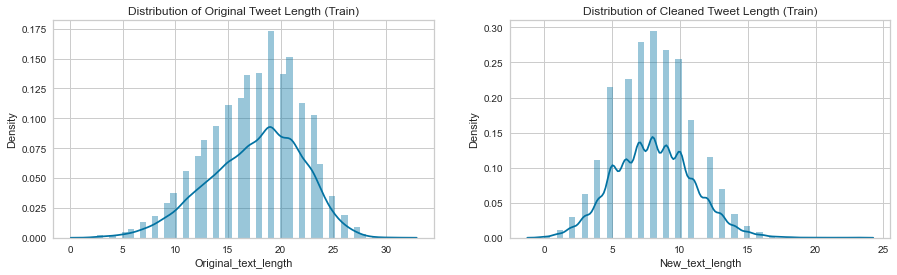

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(df_train['Original_text_length'], ax = axes[0])
sns.distplot(df_train['New_text_length'], ax = axes[1])

axes[0].title.set_text("Distribution of Original Tweet Length (Train)")
axes[1].title.set_text("Distribution of Cleaned Tweet Length (Train)")

/Users/thepe/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/thepe/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



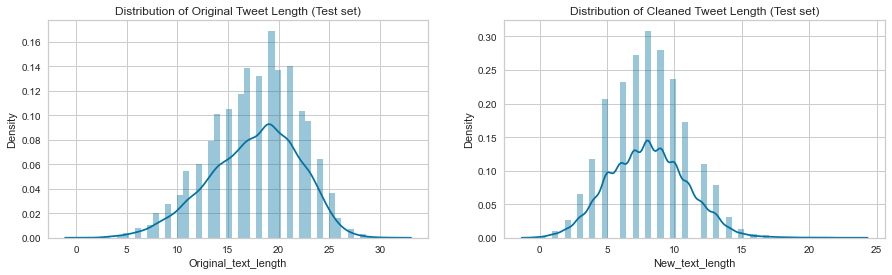

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(df_test['Original_text_length'], ax = axes[0])
sns.distplot(df_test['New_text_length'], ax = axes[1])

axes[0].title.set_text("Distribution of Original Tweet Length (Test set)")
axes[1].title.set_text("Distribution of Cleaned Tweet Length (Test set)")

#### Visualisation of trending words used for different sentiment distribution

In [28]:
#### Visualizing data into wordclouds

def wordcount_gen(df, sent_labels):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.sent_labels==sent_labels]['no_filter_words'].str.join(" ")])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='grey', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('Top 50 {} Sentiment Words'.format(sent_labels), fontsize=20)
    plt.axis('off')
    plt.show()
    

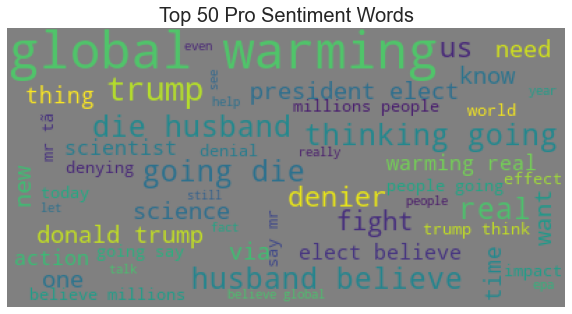

____________________________________________________________________________________________________


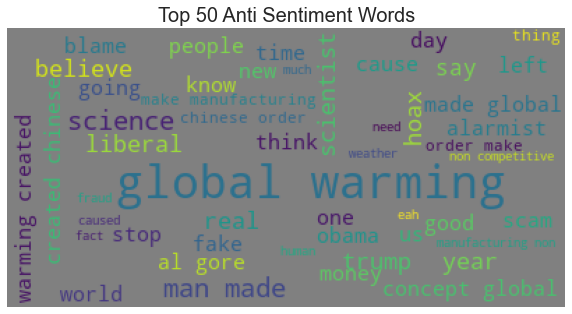

____________________________________________________________________________________________________


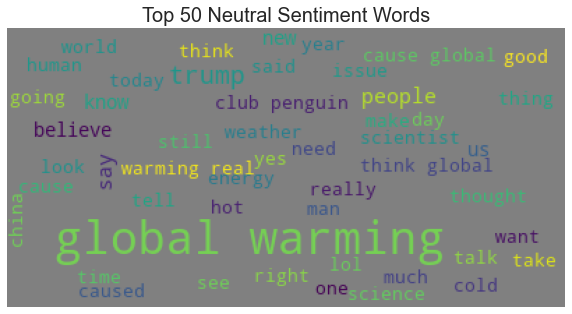

____________________________________________________________________________________________________


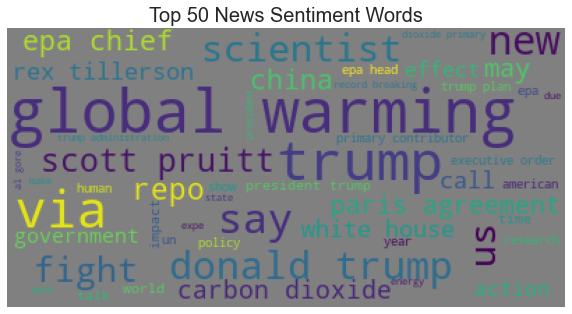

In [29]:
# Positive tweet words
wordcount_gen(df_train, 'Pro')
print("_"*100)   
# Negative tweet words
wordcount_gen(df_train, 'Anti')
print("_"*100)       
# Neutral tweet words
wordcount_gen(df_train, 'Neutral')
print("_"*100)   
# Neutral tweet words
wordcount_gen(df_train, 'News')

## 5. Modelling

#### Underlisted models would be used:

Decision Tree Classifier

RandomForest Classifier

LinearSVC(Support Vector Classifier)

Logistic Regression

Stochastic Gradient Descent (SGD)

Ridge Classiffier

### Pre-processing for Model

In [30]:
def clean_tweets(df):
    '''
    This function cleans the tweets by tokenizing, removing punctuation, 
    removing digits and removing 1 character tokens
    
    '''

    # tokenizing the tweets
    clean_tweets = df['message'].apply(TweetTokenizer().tokenize) ## first we tokenize

    # remove punctuation
    clean_tweets = clean_tweets.apply(lambda x : [token for token in x if token not in string.punctuation])

    # removing digits from the tweets
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if token not in list(string.digits)])

    # lastly we remove all one character tokens
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if len(token) > 1])
    
    df['cleaned_tweets'] = clean_tweets
    
    return df['cleaned_tweets']

In [31]:
# Data preprocessing for model building

normalizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def replace_sentiments(df):
    """
    replace keywords in the tweets  with associated sentiments
    
    'global' ----> 'negative'
    'climate' ----> 'positive'
    'MAGA'----> 'negative'
  
    """
    df['message'] = df['message'].apply(lambda x: x.replace('global', 'negative'))
    df['message'] = df['message'].apply(lambda x: x.replace('climate', 'positive'))
    df['message'] = df['message'].apply(lambda x: x.replace('MAGA', 'negative')) 

    return df['message']

df_train['message'] = replace_sentiments(df_train)
df_test['message'] = replace_sentiments(df_test)

# cleaning tweets
df_train['clean_tweets'] = clean_tweets(df_train)
df_test['clean_tweets'] = clean_tweets(df_test)


# lemmatize
df_train['clean_tweets'] = df_train['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])
df_test['clean_tweets'] = df_test['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])

[nltk_data] Downloading package wordnet to /Users/thepe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/thepe/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
df_train.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2   : Researchers say we have three years to act ...   698562   
3          1   WIRED : 2016 was a pivotal year in the war on...   573736   
4          1   : It's 2016, and a racist, sexist, positive c...   466954   

                                      cleaned_tweets  \
0  [PolySciMajor, EPA, chief, doesn't, think, car...   
1  [It's, not, like, we, lack, evidence, of, anth...   
2  [Researchers, say, we, have, three, years, to,...   
3  [WIRED, 2016, was, pivotal, year, in, the, war...   
4  [It's, 2016, and, racist, sexist, positive, ch...   

                                        no_stopwords  \
0  [polyscimajor, epa, chief, think, carbon, diox...   
1  [like, lack, evidence, anthropogenic, global, ...   
2  [researchers, say, three, years, act, climate,...   
3  [wired, 2016, pivotal, year, war, climate, cha...   
4  [2016, racist, sexist, climate, change, denyin...   

                                     no_filter_words sent_labels  \
0  [polyscimajor, epa, chief, think, carbon, diox...         Pro   
1  [like, lack, evidence, anthropogenic, global, ...         Pro   
2        [researchers, say, three, years, act, late]        News   
3                  [wired, 2016, pivotal, year, war]         Pro   
4  [2016, racist, sexist, denying, bigot, leading...         Pro   

   Original_text_length  New_text_length  \
0                    19               13   
1                    10                6   
2                    19                6   
3                    15                5   
4                    18                7   

                                        clean_tweets  
0  [PolySciMajor, EPA, chief, doesn't, think, car...  
1  [It's, not, like, we, lack, evidence, of, anth...  
2  [Researchers, say, we, have, three, year, to, ...  
3  [WIRED, 2016, be, pivotal, year, in, the, war,...  
4  [It's, 2016, and, racist, sexist, positive, ch...

In [33]:
### Creating our X and Y 
X = df_train['clean_tweets']
y = df_train['sentiment']
X_test = df_test['clean_tweets']


In [34]:
# Splitting the data into 90% train and 10% validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42)

In [35]:
X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))
X_test = list(X_test.apply(' '.join))

#### Model Pre-processing

Since our models can only process numerical data our first step is to build a pipeline that converts text data into numeric data, In this notebook we will be focusing on two methods of feature engineering, which we will use to convert text data to numeric data, namely `TfidfVectorizer` and the `CountVectorizer`, then we will train our models within these pipelines

We would first checkout which to be used between CountVectorizer and TfidfVectorizer

#### Buidling Classification Pipelines

In order to decide which feature extraction method we will use between the TF-IDF and the CountVectorizer for the remainder of the notebook, we will build pipelines using both methods and check which approach ahs the highest accuracy on average

In [36]:
# DecisionTreeClassifier Pipeline
tree_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])
tree_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('tree', DecisionTreeClassifier()),])


# RandomForestClassifier Pipeline
rfc_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])
rfc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('rfc', RandomForestClassifier()),])


# LinearSVC Pipeline
Lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
Lsvc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('svc', LinearSVC()),])



# Logistic Regression pipeline
logreg_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression()),])
logreg_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('logistic', LogisticRegression()),])



# SGD Classifier pipeline
SGD_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('SGD', SGDClassifier())])
SGD_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('SGD', SGDClassifier()),])


#Ridge Classifier pipeline
ridge_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('Ridge', RidgeClassifier())])
ridge_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('Ridge', RidgeClassifier()),])

#### Model Training

Each model is trained using it's custom pipeline which will take raw text data turn it into numeric data and initial the classifier with default parameters

In [37]:
# training the decision tree pipeline
tree_tfidf.fit(X_train, y_train)
tree_count.fit(X_train, y_train)

# training the RandomForest pipleline
rfc_tfidf.fit(X_train, y_train)
rfc_count.fit(X_train, y_train)

# training the LinearSVC pipeline
Lsvc_tfidf.fit(X_train, y_train)
Lsvc_count.fit(X_train, y_train)

# training the logistic regression pipeline
logreg_tfidf.fit(X_train, y_train)
logreg_count.fit(X_train, y_train)

# training the SGD Classifier
SGD_tfidf.fit(X_train, y_train)
SGD_count.fit(X_train, y_train)


# training the Ridge classifier
ridge_tfidf.fit(X_train, y_train)
ridge_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 2))),
                ('Ridge', RidgeClassifier())])

In [38]:
# calculating average scores for the TFIDF
tree_acc =  accuracy_score(y_val,tree_tfidf.predict(X_val))
rfc_acc = accuracy_score(y_val,rfc_tfidf.predict(X_val))
lsvc_acc = accuracy_score(y_val,Lsvc_tfidf.predict(X_val))
log_acc = accuracy_score(y_val, logreg_tfidf.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_tfidf.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_tfidf.predict(X_val))

tfidf_avg_accuracy = [tree_acc,rfc_acc,lsvc_acc,log_acc,sgd_acc,ridge_acc]

In [39]:
tree_acc =  accuracy_score(y_val,tree_count.predict(X_val))
rfc_acc = accuracy_score(y_val,rfc_count.predict(X_val))
lsvc_acc = accuracy_score(y_val,Lsvc_count.predict(X_val))
log_acc = accuracy_score(y_val, logreg_count.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_count.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_count.predict(X_val))

CountVec = [tree_acc,rfc_acc,lsvc_acc,log_acc,sgd_acc, ridge_acc]


In [40]:
print(tfidf_avg_accuracy)
print(CountVec)

[0.611251580278129, 0.7256637168141593, 0.7408343868520859, 0.7383059418457648, 0.7313527180783818, 0.7313527180783818]
[0.6491782553729456, 0.7243994943109987, 0.7547408343868521, 0.770543615676359, 0.7597977243994943, 0.7528445006321113]


We see that on average  the models build using the `CountVectorizer` performed the best and for the remainder of this notebook we will generate our features using the `CountVectorizer`

In [41]:
TFIDF = pd.Series(tfidf_avg_accuracy, index=["Decision Tree", 'Random Forest', 'Linear SVC', 
                                             "Logistic Regression", 'SGD Classifier', 'Ridge Classifier'])
COUNT_VEC = pd.Series(CountVec, index=["Decision Tree", 'Random Forest', 'Linear SVC', 
                                             "Logistic Regression", 'SGD Classifier', 'Ridge Classifier'])

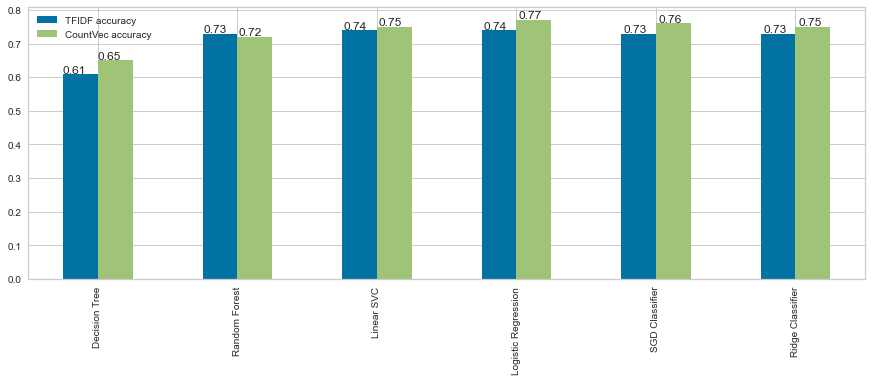

In [42]:
acc_df = pd.DataFrame()
acc_df["TFIDF accuracy"] = TFIDF
acc_df["CountVec accuracy"] = CountVec
accuracy_df = acc_df.round(2)
ax = accuracy_df.plot.bar(figsize=(15, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

From the visual above, we can conclude the Countvectorizer yields better features than TFIDF

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

Our 3 top models are `LinearSVC, Logistic Regression, and Ridge Classifier` and we want to evaluate them using classification report and confution matrix


In [43]:
# Print a classification report
Lsvc_prediction = Lsvc_count.predict(X_val)
print('\nLinearSVC Model\n', classification_report(y_val, Lsvc_prediction))


LinearSVC Model
               precision    recall  f1-score   support

          -1       0.67      0.47      0.55       126
           0       0.56      0.50      0.53       224
           1       0.81      0.84      0.82       895
           2       0.75      0.80      0.77       337

    accuracy                           0.75      1582
   macro avg       0.70      0.65      0.67      1582
weighted avg       0.75      0.75      0.75      1582



In [44]:
# Print a classification report
logreg_prediction = logreg_count.predict(X_val)
print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction))


Logistic Regression
               precision    recall  f1-score   support

          -1       0.75      0.49      0.59       126
           0       0.61      0.46      0.52       224
           1       0.80      0.88      0.84       895
           2       0.78      0.78      0.78       337

    accuracy                           0.77      1582
   macro avg       0.73      0.65      0.68      1582
weighted avg       0.76      0.77      0.76      1582



In [45]:
# The classification report 
ridge_prediction = ridge_count.predict(X_val)
print('\nRidge Classifier  Classification report :\n', classification_report(y_val, ridge_prediction))


Ridge Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.70      0.44      0.54       126
           0       0.58      0.48      0.53       224
           1       0.80      0.85      0.83       895
           2       0.72      0.78      0.75       337

    accuracy                           0.75      1582
   macro avg       0.70      0.64      0.66      1582
weighted avg       0.75      0.75      0.75      1582



### Hyperparameter Tunning

Performing hyperperameter tuning to our top 3 models using GridSearchCV

LinearSVC

Logistic Regression

Ridge Classifier

In [46]:
# We are not going to use pipelines so we need to prepare the data for this parameter tuning

df_train['message'] = replace_sentiments(df_train)
df_test['message'] = replace_sentiments(df_test)
df_train['clean_tweets'] = clean_tweets(df_train)
df_test['clean_tweets'] = clean_tweets(df_test)

normalizer = WordNetLemmatizer()
df_train['clean_tweets'] = df_train['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])
df_test['clean_tweets'] = df_test['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])



X = df_train['clean_tweets']
y = df_train['sentiment']
X_test = df_test['clean_tweets']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42)

X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))
X_test = list(X_test.apply(' '.join))

In [48]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )
vectorizer.fit(X_train)

model_save_path = 'gridsearch_vectorizer.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(vectorizer, file)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

#### Tuning LinearSVC

In [49]:
# Tuning LinearSVC using GridSearchCV
grid_lsvc = LinearSVC(C= 8.9060432109076855)
grid_lsvc.fit(X_train, y_train)

LinearSVC(C=8.906043210907686)

In [50]:
tuned_lsvc_predictions = grid_lsvc.predict(X_val)

In [51]:
# Checking the accuracy score
tuned_lsvc_acc = round(accuracy_score(y_val, tuned_lsvc_predictions),4)
print(f'\nOverall accuracy score for LinearSVC : {tuned_lsvc_acc}')


Overall accuracy score for LinearSVC : 0.7295


Results of the gridsearch method

In [52]:
# We now retrain the LinearSVC with the best parameters we got from the tuning method that performed the best

final_lsvc = LinearSVC(C=0.49417133613238384, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=3000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.001, verbose=1) 
final_lsvc.fit(X_train, y_train)
LinearSVC_prediction = final_lsvc.predict(X_val)
final_svc_acc = accuracy_score(y_val, LinearSVC_prediction)
print(f'\nOverall accuracy score for LinearSVC : {final_svc_acc}')


[LibLinear]......................**
optimization finished, #iter = 229
Objective value = -134.537257
nSV = 5644
........................****
optimization finished, #iter = 249
Objective value = -274.809893
nSV = 8237
.........................**
optimization finished, #iter = 253
Objective value = -486.133304
nSV = 10975
........................***.*
optimization finished, #iter = 251
Objective value = -300.250199
nSV = 6722

Overall accuracy score for LinearSVC : 0.7604298356510746


In [53]:
print('\nLinearSVC Model\n', classification_report(y_val, LinearSVC_prediction))


LinearSVC Model
               precision    recall  f1-score   support

          -1       0.68      0.49      0.57       126
           0       0.59      0.50      0.54       224
           1       0.81      0.85      0.83       895
           2       0.75      0.80      0.78       337

    accuracy                           0.76      1582
   macro avg       0.71      0.66      0.68      1582
weighted avg       0.75      0.76      0.75      1582



In [54]:
# Saving the model
model_save_path = 'gridsearch_final_lsvc.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(final_lsvc, file)

#### Prediction

In [55]:
preds = final_lsvc.predict(X_test)
df_test['sentiment'] = preds
df_test.head()
sub = df_test[['tweetid', 'sentiment']]
sub.to_csv('submission11.csv', index=False)

#### Tuning Logistic Regression

In [56]:
# Tuning Logistic Regression using GridSearchCV

# Retraining with best params                     
grid_Log_reg = LogisticRegression(C = 3.727593720314938, penalty = 'l2',solver='lbfgs', random_state=42)
grid_Log_reg.fit(X_train, y_train)

tunned_logreg_acc = round(accuracy_score(y_val, grid_Log_reg.predict(X_val)),4)
print(f'The accuracy score score for tuned Logistic Regression Classifier : {tunned_logreg_acc}')

The accuracy score score for tuned Logistic Regression Classifier : 0.7642


In [57]:
grid_Log_reg = LogisticRegression(C = 355.64803062231283)
grid_Log_reg.fit(X_train, y_train)

tunned_logreg_acc = round(accuracy_score(y_val, grid_Log_reg.predict(X_val)),4)
print(f'The accuracy score score for tuned Logistic Regression Classifier : {tunned_logreg_acc}')

The accuracy score score for tuned Logistic Regression Classifier : 0.7554


In [58]:
print('\nLogistic Regression Model\n', classification_report(y_val, grid_Log_reg.predict(X_val)))


Logistic Regression Model
               precision    recall  f1-score   support

          -1       0.61      0.50      0.55       126
           0       0.58      0.47      0.52       224
           1       0.80      0.86      0.83       895
           2       0.78      0.77      0.77       337

    accuracy                           0.76      1582
   macro avg       0.69      0.65      0.67      1582
weighted avg       0.75      0.76      0.75      1582



In [59]:
# Saving the model
model_save_path = 'gridsearch_logistic_regression.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(grid_Log_reg, file)

In [60]:
preds = grid_Log_reg.predict(X_test)
df_test['sentiment'] = preds
df_test.head()
sub = df_test[['tweetid', 'sentiment']]
sub.to_csv('submission12.csv', index=False)

In [61]:
# We now retrain Logistic Regression with the best parameters we got from the tuning method that performed the best

final_logreg = LogisticRegression(C = 2.727593720314938, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
final_logreg.fit(X_train, y_train)
final_log_reg_prediction= final_logreg.predict(X_val) 
final_logreg_acc = round(accuracy_score(y_val, final_log_reg_prediction),4)
final_logreg_acc

0.7674

In [62]:
final_logreg_f1 = round(f1_score(y_val, final_log_reg_prediction, average = 'weighted'),4)
final_logreg_f1

0.7594

##### Predictions

In [63]:
preds = final_logreg.predict(X_test)
df_test['sentiment'] = preds
df_test.head()
sub = df_test[['tweetid', 'sentiment']]
sub.to_csv('submission13.csv', index=False)

#### Tuning Ridge Classifier

We would be using Parfit

In [64]:
!pip install parfit

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


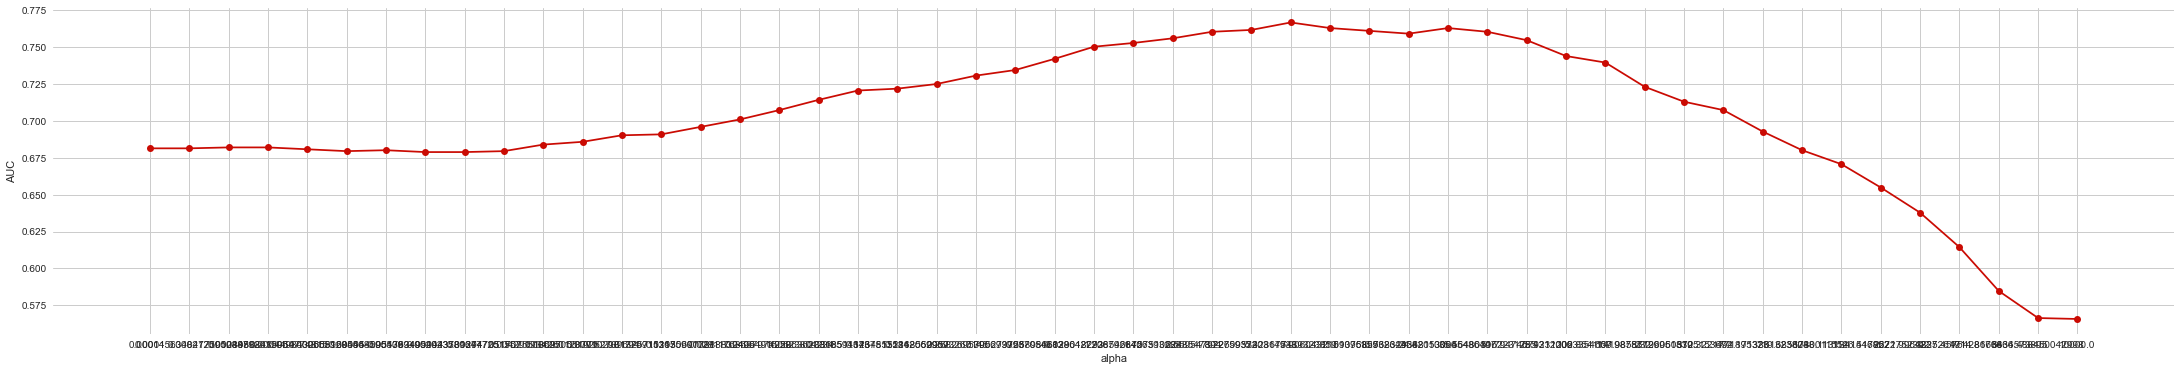

RidgeClassifier(alpha=5.428675439323859) 
 0.7667509481668774


In [65]:
# Tuning Ridge classifier using parfit
grid = {
   'alpha':  np.logspace(-4, 4, 50), # learning rate
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(RidgeClassifier, paramGrid,
          X_train, y_train, X_val, y_val, 
          metric = accuracy_score,
          scoreLabel = "AUC")

print(bestModel,'\n' ,bestScore)

In [66]:
# retrain the model with best params
ridge_grid = RidgeClassifier(alpha=12.513933993264458)
ridge_grid.fit(X_train, y_train)

RidgeClassifier(alpha=12.513933993264459)

In [67]:
# accuracy of the ridge gridsearch model
print(f1_score(y_val, ridge_grid.predict(X_val), average = 'weighted'))

0.7492921106528154


In [68]:
# retraining the best Ridge Classifer model we have
ridge_tuned = RidgeClassifier(alpha=13.428675439323859, class_weight=None, copy_X=True,
                fit_intercept=True, max_iter=None, normalize=False,
                random_state=None, solver='auto', tol=0.001) 
ridge_tuned.fit(X_train, y_train)

/Users/thepe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



RidgeClassifier(alpha=13.42867543932386, normalize=False)

In [69]:
# Checking the accuracy score
ridge_predictions =ridge_tuned.predict(X_val)

ridge_acc_2 = round(accuracy_score(y_val, ridge_predictions),4)
print(f'\nOverall accuracy score for Ridge Classifier accuracy Score : {ridge_acc}')
ridge_f1_2 = round(f1_score(y_val, ridge_predictions, average="weighted"),4)
print(f'\nWeighted avg f1 score for Ridge Classifier : {ridge_f1_2}')


Overall accuracy score for Ridge Classifier accuracy Score : 0.7528445006321113

Weighted avg f1 score for Ridge Classifier : 0.7502


In [70]:
print('\n Ridge Model\n', classification_report(y_val, ridge_predictions))


 Ridge Model
               precision    recall  f1-score   support

          -1       0.81      0.44      0.57       126
           0       0.67      0.42      0.52       224
           1       0.78      0.89      0.83       895
           2       0.74      0.78      0.76       337

    accuracy                           0.76      1582
   macro avg       0.75      0.63      0.67      1582
weighted avg       0.76      0.76      0.75      1582



In [71]:
# Saving the model
model_save_path = 'gridsearch_ridgeclfr.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(ridge_tuned, file)
  

In [72]:
preds = ridge_tuned.predict(X_test)
df_test['sentiment'] = preds
df_test.head()
sub = df_test[['tweetid', 'sentiment']]
sub.to_csv('submission14.csv', index=False)

This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using pr

### Conclusion

We can therefore conclude that the best model is the LinearSVC